<a href="https://colab.research.google.com/github/minassy/210712_atmaCup-11/blob/main/210725_atmaCup_11_%E5%86%8D%E8%A7%A3%E9%87%88_5%E3%82%A8%E3%83%9D%E3%83%83%E3%82%AF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# データ準備

In [1]:
import os
import zipfile

In [2]:
#作業基本ディレクトリ
DIR = 'drive/MyDrive/Competition/atmaCup_11'
os.listdir(DIR)
#os.mkdir(DIR+'/data')

['data']

In [3]:
#データセットの解凍
#TARGET_PATH = 'drive/MyDrive/Competition/atmaCup_11/data/dataset_atmaCup11.zip'
#OUT_PATH = 'drive/MyDrive/Competition/atmaCup_11/data'
#with zipfile.ZipFile(TARGET_PATH, 'r') as f: 
#  f.extractall(path=OUT_PATH)

In [4]:
#os.listdir(DIR+'/data')

In [5]:
#os.mkdir(DIR + '/data/photos')

In [6]:
#photos.zipの解凍
#TARGET_PATH = 'drive/MyDrive/Competition/atmaCup_11/data/photos.zip'
#OUT_PATH = 'drive/MyDrive/Competition/atmaCup_11/data/photos'
#with zipfile.ZipFile(TARGET_PATH, 'r') as f: 
#  f.extractall(path=OUT_PATH)

In [7]:
#ディレクトリ構造
print('基本：', DIR)
print('データ：' , DIR+'/data')
print('画像データ' , DIR+'/data/photos')

基本： drive/MyDrive/Competition/atmaCup_11
データ： drive/MyDrive/Competition/atmaCup_11/data
画像データ drive/MyDrive/Competition/atmaCup_11/data/photos


# データの読み込み

In [8]:
import pandas as pd
import numpy as np
from glob import glob

import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import seaborn as sns

テーブルデータの確認

In [9]:
os.listdir(DIR+'/data')

['dataset_atmaCup11.zip',
 'atmaCup#11_sample_submission.csv',
 'materials.csv',
 'photos.zip',
 'techniques.csv',
 'test.csv',
 'train.csv',
 'photos',
 'outputs_tutorial#1']

In [10]:
DIR_DATA = DIR+ '/data'
train_df = pd.read_csv(DIR_DATA+ '/train.csv')
test_df = pd.read_csv(DIR_DATA+ '/test.csv')
material_df = pd.read_csv(DIR_DATA+ '/materials.csv')
technique_df = pd.read_csv(DIR_DATA+ '/techniques.csv')

# データ理解(tabular)

In [11]:
from matplotlib_venn import venn2

In [12]:
#学習データ、テストデータ、マテリアル、テクニック
Dataframe = technique_df
#Dataframe.shape
#Dataframe.columns
#Dataframe.head()
#Dataframe.info()
#Dataframe.isnull().sum()

# 画像データを使用したモデルの作成

In [20]:
!pip install ipyplot
!pip install python-vivid

     |████████████████████████████████| 76 kB 2.6 MB/s 
     |████████████████████████████████| 301 kB 14.5 MB/s 
     |████████████████████████████████| 164 kB 45.2 MB/s 
     |████████████████████████████████| 80 kB 8.4 MB/s 
     |████████████████████████████████| 75 kB 4.2 MB/s 
     |████████████████████████████████| 141 kB 47.3 MB/s 
     |████████████████████████████████| 111 kB 46.3 MB/s 
     |████████████████████████████████| 49 kB 6.3 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=749b4f74e03b4ce1fe0f0d19a8e5ce77db9b6416cbc95da254e5d71b0a9fbb81
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [21]:
import ipyplot

from PIL import Image

from torchvision import transforms as T

import torch
from torchvision.models import resnet34
from torch import nn

from torch.optim import Adam
from torch.utils import data

from torch.optim.optimizer import Optimizer
from collections import defaultdict

from vivid.utils import timer

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

from tabulate import tabulate


        WARNING! Google Colab Environment detected!
        You might encounter issues while running in Google Colab environment.
        If images are not displaying properly please try setting `base_64` param to `True`.
        


画像データの読み込み

In [22]:
photo_dir = DIR+'/data/photos'
#画像ファイルのパス設定の関数
def to_img_path(object_id):
  return os.path.join(photo_dir, f'{object_id}.jpg')

In [23]:
#画像ファイル読み込みの関数
def read_image(object_id):
  return Image.open(to_img_path(object_id))

In [24]:
#画像ファイル数
print(sum(os.path.isfile(os.path.join(photo_dir, name)) for name in os.listdir(photo_dir)), '枚')

9856 枚


In [81]:
img = read_image(train_df['object_id'].iat[3936])

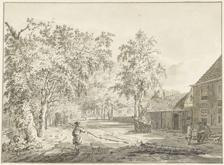

In [82]:
img

モデルの定義

In [83]:
model = resnet34(pretrained=False)#事前学習は無し。

In [84]:
#model

In [85]:
#データオーギュメンテーション。
converter = T.Compose([
                       T.RandomHorizontalFlip(p=1),
                       T.ColorJitter(brightness=.5, contrast=.5),
                       T.ToTensor()#画像をテンソルオブジェクトに変更する。
])


In [86]:
x = converter(img)

In [87]:
type(img)#元の画像はPIL。

PIL.JpegImagePlugin.JpegImageFile

In [88]:
type(x)#PILではなくtensorになっている。

torch.Tensor

T.ToTensorにて、pytorchで扱えるテンソル化。  
⇒resnet34はtorchのテンソルを受け取るので、この変換が必要。

In [89]:
x.shape#RGBの3チャンネル、高さ、横

torch.Size([3, 165, 224])

In [90]:
x.unsqueeze(0).shape#モデルは、入力時に追加で1次元必要。そのままだと、3枚、165チャンネル、高さ224とモデルは認識してしまうため。

torch.Size([1, 3, 165, 224])

In [91]:
output = model(x.unsqueeze(0))

In [93]:
output.shape#1枚、1000次元の出力が返ってきた。もともとのresnetが1000クラスの出力タスクであるため。⇒最終層の修正が必要。

torch.Size([1, 1000])

・タスクの出力は"年代"の一次元なので、最終層を書き換え。

In [94]:
model.fc = nn.Linear(in_features=512, out_features=1, bias=True)

In [95]:
model(x.unsqueeze(0))

tensor([[-0.9365]], grad_fn=<AddmmBackward>)

以上より、モデル(Resnet34)を使った予測値の出力ができるようになった。  
ただし、ただのランダムな出力になるだけなので、  
Xを入れたときの年代yを出力する、というように修正をおこなう。  

# 学習スキームの定義

下記のループを繰り返す。  
①入力データxをモデルに入れ、出力zを作成  
②あるxに対応する正解ラベルyとzを目的関数(今回はRMSE)に入れ、ズレ量(loss)を計算  
③lossの情報を基にし、最適化手法によりモデルを更新

目的関数の定義

In [97]:
criterion = nn.MSELoss()

In [98]:
criterion(torch.Tensor([3]), torch.Tensor([10]))

tensor(49.)

In [99]:
#最適化手法の定義。
optimizer = Adam(params=model.parameters(), lr=1e-3)
#第一引数；どのモデルのパラメータを更新したいかを指定。
#第二引数：LearningRate。決まった値はないが、adamの場合、1e-3がよく使われるらしい。

モデルの学習(画像一枚)

①学習データをtorch.Tensorの形式で用意する。

In [109]:
x = converter(img)
x = x.unsqueeze(0)

In [110]:
label = train_df['target'].iat[0]
label = torch.Tensor(label)
label = label.reshape(-1, 1)

②学習データをモデルに入れ、lossを目的関数で計算

In [111]:
output = model(x)

In [112]:
loss = criterion(output, label)

③loss値から、optimizerがmodelを更新する

In [113]:
# zero_grad は今ある勾配の情報をリセットする関数. このあとに計算される勾配を元にして最適化される
optimizer.zero_grad()

In [114]:
#lossから勾配計算
loss.backward()

In [115]:
#最適化ステップを1つ進める。
optimizer.step()

In [117]:
print(loss.item())

inf


学習の関数化

In [57]:
IMG_MEAN = [0.485, 0.456, 0.406]
IMG_STD = [0.229, 0.224, 0.225]

In [118]:
class AtmaDataset(data.Dataset):
    """atmaCup用にデータ読み込み等を行なうデータ・セット"""
    object_path_key = "object_path"
    label_key = "target"

    @property
    def meta_keys(self):
        retval = [self.object_path_key]

        if self.is_train:
            retval += [self.label_key]

        return retval

    def __init__(self, meta_df: pd.DataFrame, is_train=True):
        """
        args:
            meta_df: 
                画像へのパスと label 情報が含まれている dataframe
                必ず object_path に画像へのパス, target に正解ラベルが入っている必要があります

            is_train:
                True のとき学習用のデータ拡張を適用します.
                False の時は単に size にリサイズを行います
        """

        self.is_train = is_train
        for k in self.meta_keys:
            if k not in meta_df:
                raise ValueError("meta df must have {}".format(k))

        self.meta_df = meta_df.reset_index(drop=True)
        self.index_to_data = self.meta_df.to_dict(orient="index")

        size = (224, 224)

        additional_items = (
            [T.Resize(size)]
            if not is_train
            else [
                T.RandomGrayscale(p=0.2),
                T.RandomVerticalFlip(),
                T.RandomHorizontalFlip(),
                T.ColorJitter(
                    brightness=0.3,
                    contrast=0.5,
                    saturation=[0.8, 1.3],
                    hue=[-0.05, 0.05],
                ),
                T.RandomResizedCrop(size),
            ]
        )

        self.transformer = T.Compose(
            [*additional_items, T.ToTensor(), T.Normalize(mean=IMG_MEAN, std=IMG_STD)]
        )

    def __getitem__(self, index):#重要。インデックスを採取して、対応する画像とラベルを返す。
        data = self.index_to_data[index]

        obj_path, label = data.get(self.object_path_key), data.get(self.label_key, -1)
        img = Image.open(obj_path)
        img = self.transformer(img)
        return img, label

    def __len__(self):#重要。データの長さを指定している。これが無いと打ち切る場所がわからない。
        return len(self.meta_df)

In [119]:
train_meta_df = train_df[['target', 'object_id']].copy()
train_meta_df['object_path'] = train_meta_df['object_id'].map(to_img_path)

dataset = AtmaDataset(meta_df=train_meta_df)

In [120]:
# このデータセットで場合、同時に 54 の画像に対応した tensor と label が作られる。4並列でデータ処理をするように回してね。
loader = data.DataLoader(dataset=dataset, batch_size=54, num_workers=4)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [121]:
  for x_tensor, y in loader:#画像のテンソルとラベルを返してくれる。
    break#for文の途中で止めて中を見る。

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [123]:
#最初の次元が、設定したバッチサイズの54、3チャンネル、224、224になっていることを確認。ラベルサイズもバッチサイズに合う。
x_tensor.shape, y.shape

(torch.Size([54, 3, 224, 224]), torch.Size([54]))

学習関数の実装

In [124]:
assert torch.cuda.is_available()

DEVICE = torch.device('cuda')

In [125]:
def train(
    model: nn.Module,
    optimizer: Optimizer,
    train_loader: data.DataLoader
) -> pd.Series:

    # train にすることで model 内の学習時にのみ有効な機構が有効になります (Dropouts Layers、BatchNorm Layers...)
    model.train()

    criterion = nn.MSELoss()

    # ロスの値を保存する用に dict を用意
    metrics = defaultdict(float)
    n_iters = len(train_loader)

    for i, (x_i, y_i) in enumerate(train_loader):
        x_i = x_i.to(DEVICE)
        y_i = y_i.to(DEVICE).reshape(-1, 1).float()

        output = model(x_i)
        loss = criterion(output, y_i)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        metric_i = {
            # loss は tensor object なので item をつかって python object に戻す
            "loss": loss.item()
        }
        for k, v in metric_i.items():
            metrics[k] += v

    for k, v in metrics.items():
        metrics[k] /= n_iters

    return pd.Series(metrics).add_prefix("train_")

In [126]:
n_epochs = 10

# GPU 環境で学習するため変換. この呼び出しは破壊的
model.to(DEVICE)
optimizer = Adam(params=model.parameters(), lr=1e-3)

for epoch in range(1, n_epochs + 1):

    with timer(prefix="train: epoch={}".format(epoch)):
        score_train = train(
            model, optimizer, train_loader=loader
        )
    print(score_train)

    break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train: epoch=1 45.194[s]
train_loss    2.332194
dtype: float64


# 交差検証

In [127]:
fold = KFold(n_splits=5, shuffle=True, random_state=510)
cv = list(fold.split(X=train_df, y=train_df['target']))

In [128]:
idx_tr, idx_val = cv[0]

len(idx_tr), len(idx_val)#全体を5分割して、4:1にする。

(3149, 788)

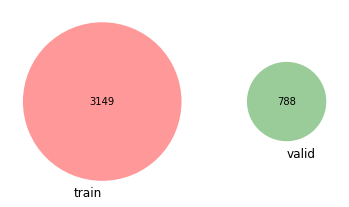

In [68]:
# train / valid で index の重複はない
venn2(subsets=(set(idx_tr), set(idx_val)), set_labels=('train', 'valid'))

In [69]:
# 最初の fold だけで考える
#⇒見積もりの正確性は落ちるが、たくさんの実験パターンを実行できるメリットがある。
#特に、一つの fold の学習に時間がかかる場合、実験条件のPDCAを回す速度を優先しfold を削ることがある。
cv = cv[:1]

検証の実装

predict: 与えられたデータ (data-loader) に対しての予測値を計算  
valid: 与えられたモデル・データローダを使って検証フェーズを実行。  
スコアの dict と予測した値を返す

In [129]:
def predict(model: nn.Module, loader: data.DataLoader) -> np.ndarray:
    # train とは逆で model 内の学習時にのみ有効な機構がオフになります (Dropouts Layers、BatchNorm Layers...)
    model.eval()

    predicts = []

    for x_i, y_i in loader:

        # 明示的に勾配を計算しないように指定することができます. 
        # この関数ではモデルの更新はせずに単に出力だけを使いますので勾配は不要です.
        with torch.no_grad():
            output = model(x_i.to(DEVICE))

        predicts.extend(output.data.cpu().numpy())

    pred = np.array(predicts).reshape(-1)
    return pred


def calculate_metrics(y_true, y_pred) -> dict:
    """正解ラベルと予測ラベルから指標を計算する"""
    # return regression_metrics(y_true, y_pred)

    return {
        'rmse': mean_squared_error(y_true, y_pred) ** .5
    }


def valid(
    model: nn.Module, 
    y_valid: np.ndarray, 
    valid_loader: data.DataLoader
) -> pd.Series:
    """検証フェーズ
    与えられたモデル・データローダを使って検証フェーズを実行。スコアの dict と予測した値を返す
    """

    pred = predict(model, valid_loader)
    score = calculate_metrics(y_valid, pred)

    valid_score = pd.Series(score)
    return valid_score.add_prefix("valid_"), pred

In [130]:
def run_fold(
    model: nn.Module, 
    train_df: pd.DataFrame, 
    valid_df: pd.DataFrame, 
    y_valid: np.ndarray, 
    output_dir: str, 
    n_epochs=30) -> np.ndarray:
    """
    train / valid に分割されたデータで学習と同時に検証を行なう
    """

    os.makedirs(output_i, exist_ok=True)

    optimizer = Adam(model.parameters(), lr=1e-3)

    # 0: 前準備. dataframe から data loader を作成
    train_dataset = AtmaDataset(meta_df=train_df)
    # 検証用の方は is_train=False にしてデータ拡張オフにする
    valid_dataset = AtmaDataset(meta_df=valid_df, is_train=False)

    train_loader = data.DataLoader(
        train_dataset, batch_size=64, shuffle=True, drop_last=True, num_workers=4
    )
    valid_loader = data.DataLoader(valid_dataset, batch_size=256, num_workers=4)

    # --- 保存のための変数定義
    score_df = pd.DataFrame()
    valid_score = np.inf
    valid_score_key = "valid_rmse"
    valid_best_pred = None

    for epoch in range(1, n_epochs + 1):
        print(f'start {epoch}')

        # 1: 学習用データで学習を実行。学習時のロスを取得
        with timer(prefix="train: epoch={}".format(epoch)):
            score_train = train(
                model, optimizer, train_loader
            )

        # 2: 検証データでのスコアを計算
        with timer(prefix="validate"):
            score_valid, y_valid_pred = valid(model=model, valid_loader=valid_loader, y_valid=y_valid)


        # --- 学習のロスと検証スコアの値をデータフレームに追加
        row = pd.concat([score_train, score_valid])
        row["epoch"] = epoch
        row = pd.DataFrame([row])
        print(tabulate(row, headers=row.columns))
        score_df = pd.concat([score_df, row], ignore_index=True)
        # ---

        # 今の検証スコアと過去最高のスコアを比較
        current_score = score_valid[valid_score_key]
        if current_score < valid_score:
            # スコア改善したときモデルを保存する
            print(f'validation score is improved!! {valid_score:.4f} -> {current_score:.4f}')
            torch.save(
                model.state_dict(), os.path.join(output_dir, 'model_best.pth')
            )
            valid_score = current_score
            valid_best_pred = y_valid_pred

    score_df.to_csv(os.path.join(output_dir, 'score.csv'), index=False)
    return valid_best_pred

CrossValidationの枠組みで学習の実行

In [131]:
output_dir = os.path.join(DIR+'/data', "outputs_tutorial#1")
os.makedirs(output_dir, exist_ok=True)

In [138]:
def get_output_dir(n_cv: int):
    return os.path.join(output_dir, 'simple_resnet', f'cv={n_cv}')

oof = np.zeros((len(train_df), ), dtype=np.float32)

for i, (idx_tr, idx_valid) in enumerate(cv):
    output_i = get_output_dir(i)
    model = resnet34(pretrained=False)
    model.fc = nn.Linear(in_features=512, out_features=1, bias=True)

    model.to(DEVICE)

    oof_i = run_fold(
        model=model, 
        train_df=train_meta_df.iloc[idx_tr], 
        valid_df=train_meta_df.iloc[idx_valid], 
        y_valid=train_meta_df['target'].values[idx_valid],
        output_dir=output_i,

        # 今は 1 ですぐ終わるようにしている. 本当は validation score の値を見つつ適宜設定する
        n_epochs=5
    )

    oof[idx_valid] = oof_i

start 1


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train: epoch=1 34.439[s]
validate 5.295[s]
      train_loss    valid_rmse    epoch
--  ------------  ------------  -------
 0       1.98304        1.0016        1
validation score is improved!! inf -> 1.0016
start 2


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train: epoch=2 34.715[s]
validate 5.154[s]
      train_loss    valid_rmse    epoch
--  ------------  ------------  -------
 0      0.950802      0.972003        2
validation score is improved!! 1.0016 -> 0.9720
start 3


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train: epoch=3 34.650[s]
validate 5.256[s]
      train_loss    valid_rmse    epoch
--  ------------  ------------  -------
 0      0.930344      0.968642        3
validation score is improved!! 0.9720 -> 0.9686
start 4


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train: epoch=4 34.826[s]
validate 5.178[s]
      train_loss    valid_rmse    epoch
--  ------------  ------------  -------
 0      0.935324        1.0501        4
start 5


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train: epoch=5 34.685[s]
validate 5.201[s]
      train_loss    valid_rmse    epoch
--  ------------  ------------  -------
 0      0.942502       1.00246        5
start 1


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train: epoch=1 34.578[s]
validate 5.098[s]
      train_loss    valid_rmse    epoch
--  ------------  ------------  -------
 0       2.63148       1.03168        1
validation score is improved!! inf -> 1.0317
start 2


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train: epoch=2 34.990[s]
validate 5.228[s]
      train_loss    valid_rmse    epoch
--  ------------  ------------  -------
 0      0.975232      0.963842        2
validation score is improved!! 1.0317 -> 0.9638
start 3


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train: epoch=3 34.744[s]
validate 5.239[s]
      train_loss    valid_rmse    epoch
--  ------------  ------------  -------
 0      0.961397      0.965709        3
start 4


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train: epoch=4 34.642[s]
validate 5.168[s]
      train_loss    valid_rmse    epoch
--  ------------  ------------  -------
 0      0.959257      0.963779        4
validation score is improved!! 0.9638 -> 0.9638
start 5


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train: epoch=5 34.755[s]
validate 5.232[s]
      train_loss    valid_rmse    epoch
--  ------------  ------------  -------
 0      0.965103      0.977872        5
start 1


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train: epoch=1 34.556[s]
validate 5.180[s]
      train_loss    valid_rmse    epoch
--  ------------  ------------  -------
 0       1.98312      0.968541        1
validation score is improved!! inf -> 0.9685
start 2


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train: epoch=2 34.786[s]
validate 5.263[s]
      train_loss    valid_rmse    epoch
--  ------------  ------------  -------
 0      0.975694       1.03499        2
start 3


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train: epoch=3 34.612[s]
validate 5.203[s]
      train_loss    valid_rmse    epoch
--  ------------  ------------  -------
 0      0.989796       1.06502        3
start 4


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train: epoch=4 34.541[s]
validate 5.145[s]
      train_loss    valid_rmse    epoch
--  ------------  ------------  -------
 0      0.940584      0.944431        4
validation score is improved!! 0.9685 -> 0.9444
start 5


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train: epoch=5 34.492[s]
validate 5.129[s]
      train_loss    valid_rmse    epoch
--  ------------  ------------  -------
 0      0.937881      0.985833        5
start 1


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train: epoch=1 34.624[s]
validate 5.252[s]
      train_loss    valid_rmse    epoch
--  ------------  ------------  -------
 0       3.27201      0.998093        1
validation score is improved!! inf -> 0.9981
start 2


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train: epoch=2 34.717[s]
validate 5.210[s]
      train_loss    valid_rmse    epoch
--  ------------  ------------  -------
 0      0.969508      0.969285        2
validation score is improved!! 0.9981 -> 0.9693
start 3


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train: epoch=3 34.728[s]
validate 5.222[s]
      train_loss    valid_rmse    epoch
--  ------------  ------------  -------
 0      0.965806      0.949439        3
validation score is improved!! 0.9693 -> 0.9494
start 4


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train: epoch=4 34.691[s]
validate 5.197[s]
      train_loss    valid_rmse    epoch
--  ------------  ------------  -------
 0      0.951595      0.918533        4
validation score is improved!! 0.9494 -> 0.9185
start 5


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train: epoch=5 34.749[s]
validate 5.110[s]
      train_loss    valid_rmse    epoch
--  ------------  ------------  -------
 0      0.965649      0.926144        5
start 1


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train: epoch=1 34.870[s]
validate 5.193[s]
      train_loss    valid_rmse    epoch
--  ------------  ------------  -------
 0       1.89188       4.04023        1
validation score is improved!! inf -> 4.0402
start 2


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train: epoch=2 34.767[s]
validate 5.184[s]
      train_loss    valid_rmse    epoch
--  ------------  ------------  -------
 0      0.972137       0.97187        2
validation score is improved!! 4.0402 -> 0.9719
start 3


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train: epoch=3 34.708[s]
validate 5.163[s]
      train_loss    valid_rmse    epoch
--  ------------  ------------  -------
 0      0.970839      0.942754        3
validation score is improved!! 0.9719 -> 0.9428
start 4


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train: epoch=4 34.577[s]
validate 5.225[s]
      train_loss    valid_rmse    epoch
--  ------------  ------------  -------
 0      0.968973      0.927128        4
validation score is improved!! 0.9428 -> 0.9271
start 5


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train: epoch=5 34.865[s]
validate 5.230[s]
      train_loss    valid_rmse    epoch
--  ------------  ------------  -------
 0      0.945123      0.920481        5
validation score is improved!! 0.9271 -> 0.9205


FoldOutした予測値でのスコア確認

In [139]:
calculate_metrics(train_df['target'], oof)

{'rmse': 0.9434179154543798}

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


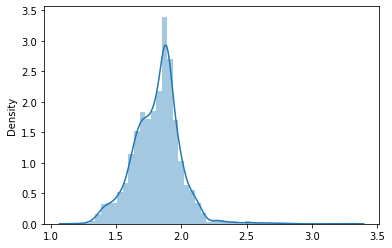

In [140]:
sns.distplot(oof)

# Submission を作る

In [141]:
def create_metadata(input_df):
    out_df = input_df[['object_id']].copy()
    out_df['object_path'] = input_df['object_id'].map(to_img_path)

    if "target" in input_df:
        out_df["target"] = input_df["target"]

    return out_df

# train と似たようなことをするので、次回から楽したいとおもって `create_metadata` という関数を作りました
test_meta_df = create_metadata(test_df)

# 学習時のデータ拡張はオフにしたいので is_train=False としている
test_dataset = AtmaDataset(meta_df=test_meta_df, is_train=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=128, drop_last=False, num_workers=4)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [142]:
test_predictions = []

for i in range(len(cv)):
    output_i = get_output_dir(i)#出力先のディレクトリをとってくる。

    model = resnet34(pretrained=False)
    model.fc = nn.Linear(in_features=512, out_features=1, bias=True)

    # 最も良かった重みを読みだす
    # https://pytorch.org/tutorials/beginner/saving_loading_models.html
    model_path = os.path.join(output_i, 'model_best.pth')

    model.load_state_dict(torch.load(model_path))

    # GPU環境で予測するため `to` で変換
    model.to(DEVICE)

    with timer(prefix=f'pred cv={i}'):
        y_pred_i = predict(model, loader=test_loader)

    test_predictions.append(y_pred_i)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


pred cv=0 22.713[s]
pred cv=1 23.088[s]
pred cv=2 22.648[s]
pred cv=3 22.574[s]
pred cv=4 22.881[s]


submission file として保存

In [144]:
# すべての予測の平均値を使う
pred_mean = np.array(test_predictions).mean(axis=0)

pd.DataFrame({
    "target": pred_mean
}).to_csv(os.path.join(output_dir, "0003__submission.csv"), index=False)